In [1]:
!pip install scikit-optimize skorch


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from scipy.stats import uniform, randint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import loguniform

import torchvision.transforms as transforms
from torchvision.datasets import Caltech101
from torch.utils.data import Subset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [3]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class Caltech101DatasetWrapper(Caltech101):
    def __init__(self, root, transform=None, **kwargs):
        super().__init__(root, **kwargs)
        self._transform = transform

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        if img.mode != "RGB":
            img = img.convert("RGB")
        if self._transform:
            img = self._transform(img)
        return img, label

full_dataset = Caltech101DatasetWrapper(
    root="./data",
    download=True,
    transform=simple_transform
)

unique_labels = np.unique(full_dataset.y)
num_classes = len(unique_labels)
print("Unique labels:", unique_labels)
print("Number of classes:", num_classes)

all_indices = np.arange(len(full_dataset))
labels = np.array(full_dataset.y)

train_val_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, stratify=labels, random_state=42
)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.1,
    stratify=labels[train_val_indices], random_state=42
)

print("Train size:", len(train_indices))
print("Val size:  ", len(val_indices))
print("Test size: ", len(test_indices))

Files already downloaded and verified
Unique labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
Number of classes: 101
Train size: 6246
Val size:   695
Test size:  1736


In [4]:
class SubsetWithTransform(Subset):
    def __init__(self, dataset, indices, transform=None):
        super().__init__(dataset, indices)
        self.override_transform = transform

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        img, label = self.dataset[actual_idx]
        if self.override_transform is not None:
            img = self.override_transform(img)
        return img, label

train_dataset = SubsetWithTransform(full_dataset, train_indices)
val_dataset   = SubsetWithTransform(full_dataset, val_indices)
test_dataset  = SubsetWithTransform(full_dataset, test_indices)


In [5]:
class SmallCNN(nn.Module):
    def __init__(self, num_filters=32, num_classes=101):
        super().__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        # After 3 pooling ops on 64×64 => 8×8
        self.fc1 = nn.Linear(num_filters * 4 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def dataset_to_numpy(dataset):
    X_list, y_list = [], []
    for img, label in dataset:
        X_list.append(img.numpy())       
        y_list.append(label)
    X = np.stack(X_list, axis=0)        
    y = np.array(y_list, dtype=np.int64)
    return X.astype(np.float32), y

X_train, y_train = dataset_to_numpy(train_dataset)
X_val,   y_val   = dataset_to_numpy(val_dataset)
X_test,  y_test  = dataset_to_numpy(test_dataset)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val   shape:", X_val.shape,   "y_val shape:",   y_val.shape)
print("X_test  shape:", X_test.shape,  "y_test shape:",  y_test.shape)

X_train shape: (6246, 3, 64, 64) y_train shape: (6246,)
X_val   shape: (695, 3, 64, 64) y_val shape: (695,)
X_test  shape: (1736, 3, 64, 64) y_test shape: (1736,)


In [7]:
from skorch import NeuralNetClassifier

demo_net = NeuralNetClassifier(
    module=SmallCNN,
    module__num_classes=101,
    max_epochs=10,      # short for demo
    lr=1e-3,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device=device,
    verbose=1
)

print("\n--- Skorch Demo: Training 'demo_net' ---")
demo_net.fit(X_train, y_train)
val_acc_demo = demo_net.score(X_val, y_val)
test_acc_demo = demo_net.score(X_test, y_test)
print(f"Demo Net - Validation Accuracy: {val_acc_demo*100:.2f}%")
print(f"Demo Net - Test Accuracy:       {test_acc_demo*100:.2f}%")


--- Skorch Demo: Training 'demo_net' ---
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.1008       0.2232        3.6634  1.3874
      2        3.3763       0.3184        3.1912  0.8996
      3        2.9355       0.3800        2.8726  0.9216
      4        2.5346       0.4064        2.6793  0.9213
      5        2.1901       0.4464        2.5327  0.9351
      6        1.8747       0.4656        2.4615  0.9084
      7        1.5477       0.4992        2.3637  0.9202
      8        1.2841       0.5048        2.3589  0.8905
      9        1.1050       0.4992        2.5671  0.8912
     10        0.9761       0.5168        2.4282  0.8924
Demo Net - Validation Accuracy: 51.37%
Demo Net - Test Accuracy:       54.84%


In [19]:
param_distributions = {
    'lr': loguniform(1e-4, 1e-2),
    'optimizer__weight_decay': loguniform(5e-4, 2e-3),
}

param_spaces = {
    'lr': Real(1e-4, 1e-2, prior='log-uniform'),
    'optimizer__weight_decay': Real(5e-4, 2e-3, prior='log-uniform'),
}

seeds = [42, 43]

random_cv_scores = []
random_val_scores = []
bayes_cv_scores = []
bayes_val_scores = []
bayes_trajectories = []


In [20]:
for seed in seeds:
    print(f"\n=== Hyperparameter Tuning with random_state={seed} ===")

    random_net = NeuralNetClassifier(
        module=SmallCNN,
        module__num_classes=101,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.Adam,
        max_epochs=10,
        device=device,
        verbose=0
    )

    print("\n[Random Search]")
    random_search = ### Add the class for RandomizedSearchCV -- 20 iterations for 3 folds
    random_search.fit(X_train, y_train)

    random_cv_scores.append(random_search.best_score_)
    best_random_model = random_search.best_estimator_
    val_acc_random = best_random_model.score(X_val, y_val)
    random_val_scores.append(val_acc_random)

    print("Best Random Search params:", random_search.best_params_)
    print("Best CV Accuracy:         ", random_search.best_score_)
    print(f"Validation Accuracy:       {val_acc_random*100:.2f}%")

    bayes_net = NeuralNetClassifier(
        module=SmallCNN,
        module__num_classes=101,
        criterion=nn.CrossEntropyLoss,
        optimizer=optim.Adam,
        max_epochs=10,
        device=device,
        verbose=0
    )

    print("\n[Bayesian Search]")
    bayes_search = ### Add the class for RandomizedSearchCV -- 20 iterations for 3 folds

    bayes_search.fit(X_train, y_train)

    bayes_cv_scores.append(bayes_search.best_score_)
    best_bayes_model = bayes_search.best_estimator_
    val_acc_bayes = best_bayes_model.score(X_val, y_val)
    bayes_val_scores.append(val_acc_bayes)

    print("Best Bayesian Search params:", bayes_search.best_params_)
    print("Best CV Accuracy:           ", bayes_search.best_score_)
    print(f"Validation Accuracy:         {val_acc_bayes*100:.2f}%")

    res = bayes_search.optimizer_results_[0]
    bayes_trajectories.append(res.func_vals)


=== Hyperparameter Tuning with random_state=42 ===

[Random Search]
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Search params: {'lr': 0.0016738085788752138, 'optimizer__weight_decay': 0.0006066716167545475}
Best CV Accuracy:          0.45725264169068197
Validation Accuracy:       48.63%

[Bayesian Search]
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 fold


========================= Summary After All Runs =========================

Random Search CV Scores:         [0.72294977 0.02737524 0.41635192 0.96613399 0.95494329 0.14957119
 0.77916538 0.96174562 0.70789197 0.30010976 0.16343565 0.22032864
 0.72022411 0.91982249 0.36336746 0.9037377  0.08869092 0.90373524
 0.66171583 0.44881062]
Random Search CV Mean +/- Std:   0.5690 +/- 0.3213
Random Search Validation Scores: [0.516546762589928, 0.4920863309352518]
Random Search Val Mean +/- Std:  0.5043 +/- 0.0122
---------------------------------------------------------
Bayesian Search CV Scores:         [0.78601282 0.7200573  0.63147206 0.67763174 0.72057897 0.59301135
 0.78023754 0.64262254 0.16787352 0.41690655 0.92927745 0.96687635
 0.93358592 0.29262336 0.41058038 0.8337158  0.25839412 0.11347591
 0.35384011 0.68882141]
Bayesian Search CV Mean +/- Std:   0.5959 +/- 0.2536
Bayesian Search Validation Scores: [0.5093525179856115, 0.5179856115107914]
Bayesian Search Val Mean +/- Std:  0.5137 +

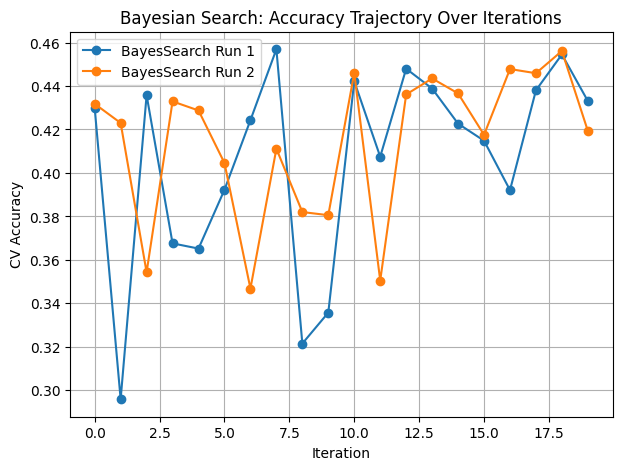

In [ ]:
def summarize_results(name, cv_scores, val_scores):
    print(f"{name} CV Scores:         {cv_scores}")
    print(f"{name} CV Mean +/- Std:   {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}")
    print(f"{name} Validation Scores: {val_scores}")
    print(f"{name} Val Mean +/- Std:  {np.mean(val_scores):.4f} +/- {np.std(val_scores):.4f}")
    print("---------------------------------------------------------")

print("\n========================= Summary After All Runs =========================\n")
summarize_results("Random Search", random_cv_scores, random_val_scores)
summarize_results("Bayesian Search", bayes_cv_scores, bayes_val_scores)

plt.figure(figsize=(7,5))
for i, func_vals in enumerate(bayes_trajectories, start=1):
    acc_vals = [-val for val in func_vals]  
    plt.plot(acc_vals, marker='o', label=f'BayesSearch Run {i}')
plt.xlabel("Iteration")
plt.ylabel("CV Accuracy")
plt.title("Bayesian Search: Accuracy Trajectory Over Iterations")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
### Train the final model with the obtained hyper-parameters